In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import timedelta

# p_project = Path(__file__).parents[2]
p_project = Path(os.getcwd()).parents[1]
path_m4 = p_project/'data/mimic4'

In [2]:
lab_df = pd.read_csv(path_m4/'processed/lab_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'valuenum', 'label']]
inputs_df = pd.read_csv(path_m4/'processed/inputs_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'amount', 'label']]
outputs_df = pd.read_csv(path_m4/'processed/outputs_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'value', 'label']]
presc_df = pd.read_csv(path_m4/'processed/prescriptions_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'dose_val_rx', 'drug']]
charts_df = pd.read_csv(path_m4/'processed/charts_processed.csv')[
    ['subject_id', 'hadm_id', 'charttime', 'valuenum', 'label']]

# Change the name of amount. Valuenum for every table
inputs_df['valuenum'] = inputs_df['amount']
inputs_df = inputs_df.drop(columns=['amount']).copy()

outputs_df['valuenum'] = outputs_df['value']
outputs_df = outputs_df.drop(columns=['value']).copy()

presc_df['valuenum'] = presc_df['dose_val_rx']
presc_df = presc_df.drop(columns=['dose_val_rx']).copy()
presc_df['label'] = presc_df['drug']
presc_df = presc_df.drop(columns=['drug']).copy()

# Tag to distinguish between lab and inputs events
inputs_df['Origin'] = 'Inputs'
lab_df['Origin'] = 'Lab'
outputs_df['Origin'] = 'Outputs'
presc_df['Origin'] = 'Prescriptions'
charts_df['Origin'] = 'Charts'

merged_df = pd.concat((inputs_df, lab_df, charts_df, outputs_df, presc_df)).reset_index()

# Check that all labels have different names.
assert(merged_df['label'].nunique() == (inputs_df['label'].nunique()+lab_df['label'].nunique()
                                        +charts_df['label'].nunique()+outputs_df['label'].nunique()
                                        +presc_df['label'].nunique()))

/tmp/ipykernel_3169417/1552399567.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  inputs_df = pd.read_csv(path_m4/'processed/inputs_processed.csv')[
/tmp/ipykernel_3169417/1552399567.py:7: DtypeWarning: Columns (12,15,18) have mixed types. Specify dtype option on import or set low_memory=False.
  presc_df = pd.read_csv(path_m4/'processed/prescriptions_processed.csv')[


In [3]:
ids_set = set(lab_df['hadm_id'].unique()) & set(inputs_df['hadm_id'].unique()) & set(outputs_df['hadm_id'].unique()) & set(presc_df['hadm_id'].unique()) & set(charts_df['hadm_id'].unique())

merged_df = merged_df.loc[merged_df['hadm_id'].isin(ids_set)]

In [4]:
merged_df.head()

,index,subject_id,hadm_id,charttime,label,valuenum,Origin
0,0,10001725,25563031.0,2110-04-11 20:51:00,Magnesium Sulfate,0.5,Inputs
1,1,10001725,25563031.0,2110-04-11 21:21:00,Magnesium Sulfate,0.5,Inputs
2,2,10001725,25563031.0,2110-04-11 21:51:00,Magnesium Sulfate,0.5,Inputs
3,3,10001725,25563031.0,2110-04-11 22:21:00,Magnesium Sulfate,0.5,Inputs
4,4,10001725,25563031.0,2110-04-11 22:31:00,Magnesium Sulfate,0.5,Inputs


In [5]:
icustay_df = pd.read_csv(path_m4/'raw/icu/icustays.csv.gz', compression='gzip')

icustay_df['outtime'] = pd.to_datetime(icustay_df['outtime'])

merged_df_tmp=pd.merge(merged_df, icustay_df[['hadm_id', 'outtime']], on='hadm_id')

merged_df_tmp2 = merged_df_tmp[merged_df_tmp['charttime'] <= merged_df_tmp['outtime']]

merged_df = merged_df_tmp2.drop(columns=['outtime']).copy()

In [6]:
# set the timestamp as the time delta between the first chart time for each admission
merged_df['charttime'] = pd.to_datetime(
    merged_df['charttime'], format='%Y-%m-%d %H:%M:%S')
ref_time = merged_df.groupby('hadm_id')['charttime'].min()
merged_df_1 = pd.merge(ref_time.to_frame(name='ref_time'),
                       merged_df, left_index=True, right_on='hadm_id')
merged_df_1['time_stamp'] = merged_df_1['charttime']-merged_df_1['ref_time']
assert(len(merged_df_1.loc[merged_df_1['time_stamp']
       < timedelta(hours=0)].index) == 0)

# Create a label code (int) for the labels.
label_dict = dict(zip(list(merged_df_1['label'].unique()), range(
    len(list(merged_df_1['label'].unique())))))
merged_df_1['label_code'] = merged_df_1['label'].map(label_dict)

label_dict_df = pd.Series(merged_df_1['label'].unique()).reset_index()
label_dict_df.columns = ['index', 'label']
label_dict_df['label_code'] = label_dict_df['label'].map(label_dict)
label_dict_df.drop(columns=['index'], inplace=True)
label_dict_df.to_csv(path_m4/'processed/variable_name_dict.csv')

merged_df_short = merged_df_1[['hadm_id', 'valuenum', 'time_stamp', 'label_code']].rename(
    columns={'hadm_id': 'ID', 'time_stamp': 'Time'})

# The sampling interval is 1 minute
merged_df_short['Time'] = merged_df_short['Time'].dt.total_seconds().div(60).astype(int)

In [10]:
value_df = pd.pivot_table(merged_df_short, values='valuenum', index=[
                          'ID', 'Time'], columns=['label_code'], aggfunc=np.max)
mask_df = value_df.notna()

d_values = {}
d_masks = {}
for i in value_df.columns:
    d_values[i] = "Value_" + str(i)
    d_masks[i] = "Mask_" + str(i)
    
value_df.rename(columns=d_values, inplace=True)
mask_df.rename(columns=d_masks, inplace=True)

value_df.fillna(0, inplace=True)
mask_df = mask_df.astype(int)

value_df.reset_index(inplace=True)
mask_df.reset_index(inplace=True)

value_df.to_csv(path_m4/'processed/tmp_value_df.csv')
mask_df.to_csv(path_m4/'processed/tmp_mask_df.csv')

In [ ]:
import gc

del inputs_df, lab_df, outputs_df, presc_df, charts_df, merged_df, merged_df_tmp, merged_df_tmp2, merged_df_1, merged_df_short, value_df, mask_df, label_dict_df, label_dict, ref_time, icustay_df, ids_set

gc.collect()

In [2]:
df = pd.DataFrame()
for chunk1, chunk2 in zip(pd.read_csv(path_m4/'processed/tmp_value_df.csv', chunksize=2000000), pd.read_csv(path_m4/'processed/tmp_mask_df.csv', chunksize=2000000)):
    df_tmp = pd.merge(chunk1, chunk2, on=['ID', 'Time'])
    df = pd.concat((df, df_tmp))
    
df['ID'] = df['ID'].astype(int)
df.to_csv(path_m4/'processed/mimic4_full_dataset_gpts_rough.csv')

In [1]:
! cd ../../ && cut --complement -f 1,2,118 -d ',' data/mimic4/processed/mimic4_full_dataset_gpts_rough.csv | sort -g -t ',' -k1 -k2 > data/mimic4/processed/mimic4_full_dataset_gpts.csv

In [4]:
df_tmp = pd.read_csv(path_m4/'processed/mimic4_full_dataset_gpts.csv', 
                    usecols=[0,1], index_col=0)

In [5]:
df_tmp.head()

,Time
ID,
20000147,0
20000147,510
20000147,578
20000147,599
20000147,693


In [6]:
df_tmp.index.nunique()

51373

In [7]:
num_obs = df_tmp.groupby('ID')['Time'].count().sort_values()

<Axes: >

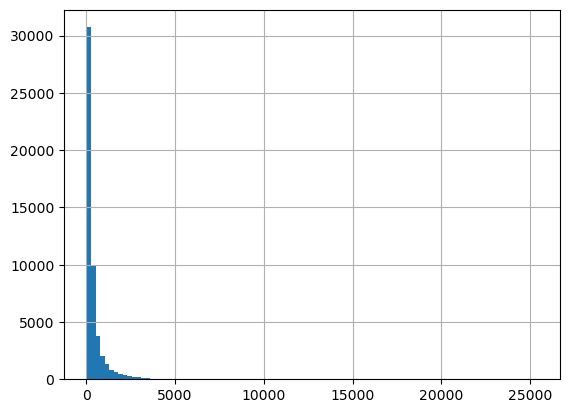

In [8]:
num_obs.hist(bins=100)

In [9]:
num_obs.describe()

count    51373.000000
mean       431.850758
std        687.038156
min         12.000000
25%        119.000000
50%        208.000000
75%        435.000000
max      25420.000000
Name: Time, dtype: float64

In [2]:
df_tmp = pd.read_csv(path_m4/'processed/mimic4_full_dataset_gpts.csv', index_col=0)

: 

: 

In [2]:
import csv
import h5py

def csv_to_hdf(csv_file, hdf_file, dataset_name='data'):
    # Open the CSV file for reading
    with open(csv_file, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        data = list(csvreader)

    # Create an HDF5 file
    with h5py.File(hdf_file, 'w') as hdf:
        # Create a dataset in the HDF5 file
        hdf.create_dataset(dataset_name, data=data)

# Convert CSV to HDF5
csv_to_hdf(path_m4/'processed/mimic4_full_dataset_gpts.csv', path_m4/'processed/mimic4_full_dataset_gpts.h5')


: 

: 

In [ ]:
import os
import pandas as pd

# Path to the large CSV file
large_csv_path = path_m4/'processed/mimic4_full_dataset_gpts.csv'

# Name of the field to split the CSV file
split_field = 'ID'

# Create a directory to store the small CSV files
output_dir = path_m4/'processed/split'

# Read the large CSV file in chunks
chunk_size = 1000000  # Adjust the chunk size according to your memory capacity
reader = pd.read_csv(large_csv_path, chunksize=chunk_size)

# Iterate over each chunk
for i, chunk in enumerate(reader):
    # Group the chunk by the split field
    groups = chunk.groupby(split_field)
    
    # Iterate over each group
    for group_name, group_data in groups:
        # Generate the output file path based on the group name
        output_file = os.path.join(output_dir, f'{group_name}.csv')
        
        # Save the group data to a small CSV file
        group_data.to_csv(output_file, index=False, mode='a', header=not os.path.exists(output_file))
        
        print(f'Saved {output_file}')

print('Splitting complete.')


In [3]:
import csv
import math

def normalize_csv(csv_path, fields_to_normalize):
    # Open the input CSV file for reading
    with open(csv_path, 'r') as input_file:
        reader = csv.reader(input_file)
        
        # Read the header row
        header = next(reader)
        
        # Find the indices of the fields to normalize
        field_indices = [header.index(field) for field in fields_to_normalize]
        
        # Initialize lists to store the values of the fields
        field_values = [[] for _ in field_indices]
        
        # Read and process each row
        for row in reader:
            for i, index in enumerate(field_indices):
                value = float(row[index])  # Convert the value to float
                field_values[i].append(value)
    
    # Calculate the mean and standard deviation for each field
    means = [sum(values) / len(values) for values in field_values]
    std_devs = [math.sqrt(sum((value - mean) ** 2 for value in values) / len(values)) for values, mean in zip(field_values, means)]
    
    # Open the input CSV file again for normalization
    with open(csv_path, 'r') as input_file:
        reader = csv.reader(input_file)
        
        # Create a new CSV file for writing the normalized data
        output_path = csv_path.replace('.csv', '_normalized.csv')
        with open(output_path, 'w', newline='') as output_file:
            writer = csv.writer(output_file)
            
            # Write the header row to the output file
            writer.writerow(header)
            
            # Read and normalize each row
            for row in reader:
                normalized_row = []
                for i, index in enumerate(field_indices):
                    value = float(row[index])  # Convert the value to float
                    mean = means[i]
                    std_dev = std_devs[i]
                    normalized_value = (value - mean) / std_dev
                    normalized_row.append(normalized_value)
                
                # Append the remaining fields as-is
                normalized_row.extend(row[index + 1:] for index in field_indices)
                
                # Write the normalized row to the output file
                writer.writerow(normalized_row)
    
    print(f'Normalization complete. Normalized data saved to {output_path}')


# Example usage
csv_path = path_m4/'processed/mimic4_full_dataset_gpts.csv'

fields_to_normalize = []
for i in range(113):
    fields_to_normalize.append("Value_" + str(i))
    
normalize_csv(csv_path, fields_to_normalize)


In [6]:
import pandas as pd

p_project


tmp_df = pd.read_csv(p_project/'tmp44.info')

<Axes: >

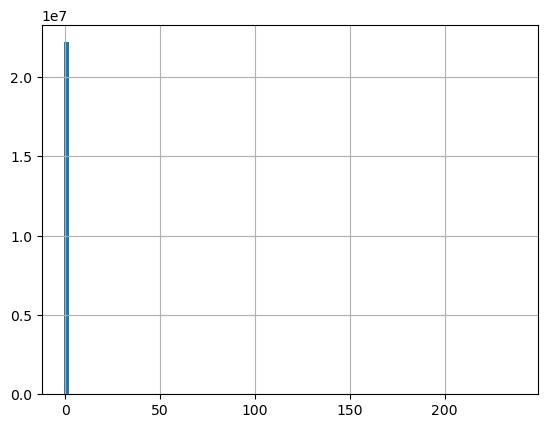

In [9]:
tmp_df["Value_1"].hist(bins=100)

In [11]:
tmp_df["Value_1"].describe()

count    2.218547e+07
mean    -6.286593e-16
std      1.620905e-01
min     -4.985253e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.373112e+02
Name: Value_1, dtype: float64